In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from datetime import date
import seaborn as sns
from pydataset import data
from env import host, user, password
import os
from sklearn.feature_selection import SelectKBest, f_regression
import sklearn.preprocessing
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLars
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

## Acquiring the data

In [2]:
swiss = data('swiss')

In [3]:
swiss

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6
Porrentruy,76.1,35.3,9,7,90.57,26.6
Broye,83.8,70.2,16,7,92.85,23.6
Glane,92.4,67.8,14,8,97.16,24.9
Gruyere,82.4,53.3,12,7,97.67,21.0
Sarine,82.9,45.2,16,13,91.38,24.4


## Prepping the data

In [4]:
scaler_minmax = sklearn.preprocessing.MinMaxScaler()
scaler_minmax.fit(swiss)
swiss_minmax = scaler_minmax.transform(swiss)
swiss_minmax = pd.DataFrame(swiss_minmax)
key = swiss.columns.tolist()
swiss_minmax.rename(columns = {i: key[i] for i in range(len(key))} , inplace = True)
swiss_minmax.drop(columns = ['Infant.Mortality'], inplace = True)
swiss.index = swiss_minmax.index

In [5]:
swiss_minmax['Infant.Mortality'] = swiss['Infant.Mortality']

In [6]:
train_validate, test = train_test_split(swiss_minmax, test_size=0.2, random_state=1920)
train, validate = train_test_split(train_validate, train_size=0.7, random_state=1920)

In [7]:
x_train = train.drop(columns = ['Infant.Mortality'])
y_train = train['Infant.Mortality']

x_validate = validate.drop(columns = ['Infant.Mortality'])
y_validate = validate['Infant.Mortality']

x_test = test.drop(columns = ['Infant.Mortality'])
y_test = test['Infant.Mortality']

(array([ 1.,  0.,  0.,  1.,  1.,  2., 10.,  1.,  6.,  3.]),
 array([10.8 , 12.21, 13.62, 15.03, 16.44, 17.85, 19.26, 20.67, 22.08,
        23.49, 24.9 ]),
 <BarContainer object of 10 artists>)

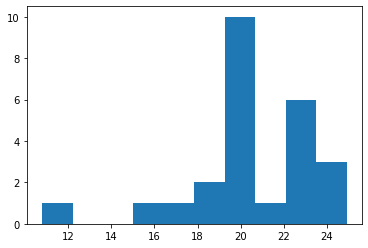

In [8]:
plt.hist(y_train)

## Establishing baselines

In [9]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [10]:
mort_pred_mean = y_train['Infant.Mortality'].mean()
y_train['mort_pred_mean'] = mort_pred_mean
y_validate['mort_pred_mean'] = mort_pred_mean

In [11]:
mort_pred_median = y_train['Infant.Mortality'].median()
y_train['mort_pred_median'] = mort_pred_median
y_validate['mort_pred_median'] = mort_pred_median

In [12]:
rmse_train = mean_squared_error(y_train['Infant.Mortality'], y_train.mort_pred_mean)**1/2
rmse_validate = mean_squared_error(y_validate['Infant.Mortality'], y_validate.mort_pred_mean)**1/2

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

rmse_train = mean_squared_error(y_train['Infant.Mortality'], y_train.mort_pred_median)**1/2
rmse_validate = mean_squared_error(y_validate['Infant.Mortality'], y_validate.mort_pred_median)**1/2

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  4.07 
Validate/Out-of-Sample:  5.64
RMSE using Median
Train/In-Sample:  4.09 
Validate/Out-of-Sample:  5.54


## Linear Regression

In [22]:
lin_reg = LinearRegression(normalize = True)
lin_reg.fit(x_train, y_train['Infant.Mortality'])
y_train['mort_pred_lm'] = lin_reg.predict(x_train)
rmse_train = mean_squared_error(y_train['Infant.Mortality'], y_train.mort_pred_lm)**1/2
y_validate['mort_pred_lm'] = lin_reg.predict(x_validate)
rmse_validate = mean_squared_error(y_validate['Infant.Mortality'], y_validate.mort_pred_lm)**1/2
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  3.169733029881621 
Validation/Out-of-Sample:  4.528451454524823


## LassoLars

In [17]:
lars = LassoLars(alpha=1.0)
lars.fit(x_train, y_train['Infant.Mortality'])
y_train['mort_pred_lars'] = lars.predict(x_train)
rmse_train = mean_squared_error(y_train['Infant.Mortality'], y_train.mort_pred_lars)**1/2
y_validate['mort_pred_lars'] = lars.predict(x_validate)
rmse_validate = mean_squared_error(y_validate['Infant.Mortality'], y_validate.mort_pred_lars)**1/2
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  4.071567999999999 
Validation/Out-of-Sample:  5.639615333333332


## TweedieRegressor (GLM)

In [18]:
glm = TweedieRegressor(power=1, alpha=0)
glm.fit(x_train, y_train['Infant.Mortality'])
y_train['mort_pred_glm'] = glm.predict(x_train)
rmse_train = mean_squared_error(y_train['Infant.Mortality'], y_train.mort_pred_glm)**1/2
y_validate['mort_pred_glm'] = glm.predict(x_validate)
rmse_validate = mean_squared_error(y_validate['Infant.Mortality'], y_validate.mort_pred_glm)**1/2
print("RMSE for Tweedie Regressor\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Tweedie Regressor
Training/In-Sample:  3.2205443273536747 
Validation/Out-of-Sample:  4.438621730398934


## Polynomial Regression

In [26]:
pf = PolynomialFeatures(degree=2)
x_train_degree2 = pf.fit_transform(x_train)
x_validate_degree2 = pf.transform(x_validate)
x_test_degree2 = pf.transform(x_test)

In [25]:
lm2 = LinearRegression(normalize=True)
lm2.fit(x_train_degree2, y_train['Infant.Mortality'])
y_train['mort_pred_lm2'] = lm2.predict(x_train_degree2)
rmse_train = mean_squared_error(y_train['Infant.Mortality'], y_train.mort_pred_lm2)**1/2
y_validate['mort_pred_lm2'] = lm2.predict(x_validate_degree2)
rmse_validate = mean_squared_error(y_validate['Infant.Mortality'], y_validate.mort_pred_lm2)**1/2
print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  1.156154542691915e-28 
Validation/Out-of-Sample:  310.2619137514882


## Evaluate

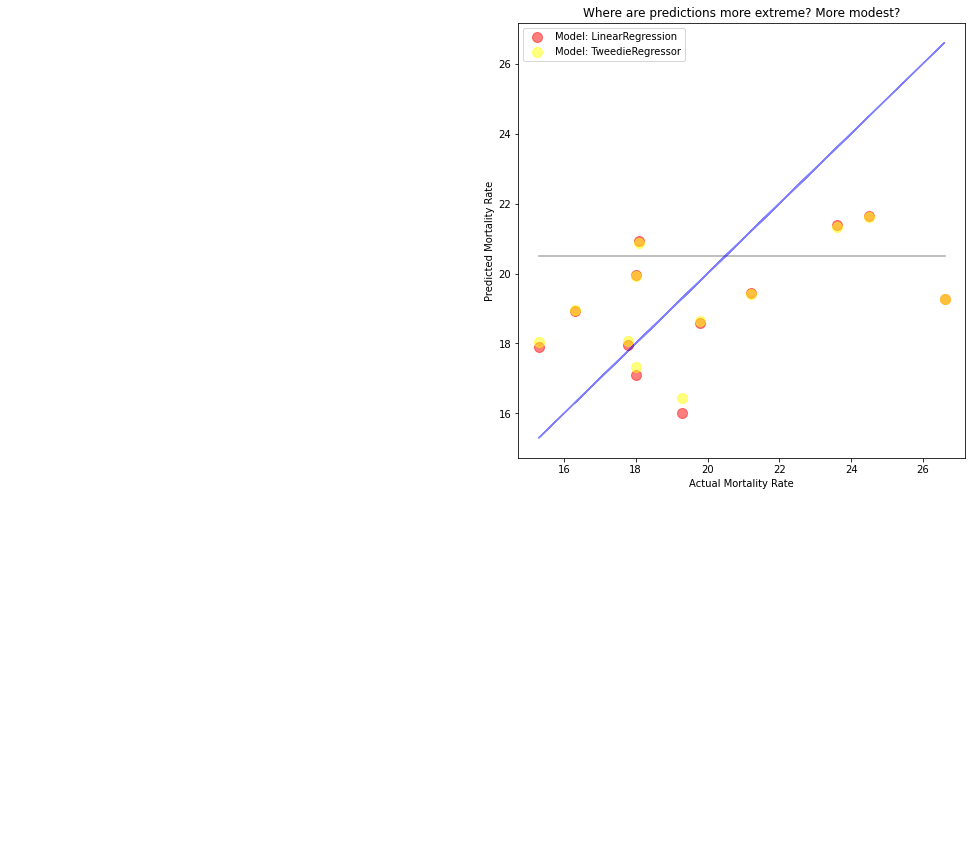

In [29]:
plt.figure(figsize=(8,8))
plt.plot(y_validate['Infant.Mortality'], y_validate.mort_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate['Infant.Mortality'], y_validate['Infant.Mortality'], alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate['Infant.Mortality'], y_validate.mort_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate['Infant.Mortality'], y_validate.mort_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
#plt.scatter(y_validate['Infant.Mortality'], y_validate.mort_pred_lm2, 
#            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Mortality Rate")
plt.ylabel("Predicted Mortality Rate")
plt.title("Where are predictions more extreme? More modest?")
plt.show()